In [1]:
import warnings; warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/home/jcbyts/Repos/')

import Utils as U
import gratings as gt


import NDN3.NDNutils as NDNutils

which_gpu = NDNutils.assign_gpu()
from scipy.ndimage import gaussian_filter
from copy import deepcopy

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt  # plotting
import seaborn as sns

import NDN3.NDN as NDN
import NDN3.Utils.DanUtils as DU

*******************************************************************************************
---> getting list of available GPUs:
[0, 1]

---> getting GPU memory map:
{0: 270, 1: 354}

---> setting up GPU with largest available memory:
   ...picking GPU # 0
*******************************************************************************************

Done!


### Simulate some data and setup NDN

169 12 13


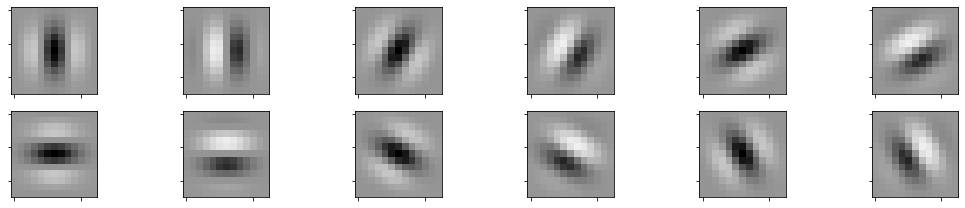

Input dimensions: [1, 13, 13]
0: temporal (lin):  	[E1/I0] N
1: normal (lin):  	[E12/I0] 
Input dimensions: [1, 1, 1]
0: temporal (lin):  	[E1/I0] N
1: normal (lin):  	[E12/I0] 
0: mult (softplus):  	[E12/I0] 


In [69]:
NT = 100000


gabor_radius = 6
karray = DU.gabor_array(gabor_radius, both_phases=True)
NP, NC = karray.shape
L = np.sqrt(NP).astype(int)
print(NP, NC, L)
DU.plot_filters(filters=karray, filter_dims=[L,L])

num_lags = 10
TF = np.exp(-np.linspace(-4,4,num_lags)**2)

cc = 0

num_saclags = 40

stim_par = NDNutils.ffnetwork_params(
    input_dims=[1, L, L],
    time_expand=[num_lags],
    layer_sizes=[1, NC],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None,1e-4], 'l2':[1e-6,1e-6]}
)

sacon_par = NDNutils.ffnetwork_params(
    xstim_n=1,
    input_dims=[1, 1, 1],
    time_expand=[num_saclags],
    layer_sizes=[1, NC],
    layer_types=['temporal', 'normal'],
    act_funcs=['lin', 'lin'],
    normalization=[1, 0],
    reg_list={'d2t': [1e-5], 'd2x': [None], 'l2':[1e-6,1e-6]}
)

comb_par = NDNutils.ffnetwork_params(
    xstim_n=None,
    ffnet_n=[0,1],
    layer_sizes=[NC],
    layer_types=['mult'], act_funcs=['softplus']
)



ndn0 = NDN.NDN([stim_par, sacon_par, comb_par], noise_dist='poisson')

Text(0.5, 0, 'saccade kernel')

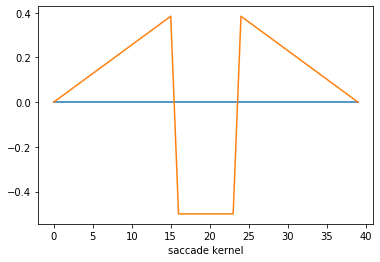

In [95]:
stim = np.random.randn(NT,L*L).astype('float32')
sacon =(np.random.rand(NT, 1) < .01).astype('float32')


ndn0.networks[0].layers[0].weights[:,0] = (TF/np.sum(TF)).astype('float32')
ndn0.networks[0].layers[1].weights = karray.astype('float32')

# saccade kernel
sk = np.linspace(0, 1, num_saclags)
sk[20:] = np.linspace(sk[19], 0, num_saclags-20)
sk[sk >.4] = -0.5

ndn1 = ndn0.copy_model()
ndn0.networks[1].layers[0].weights[:,0] *= 0 # ndn0 has zero saccade gain
ndn1.networks[1].layers[0].weights[:,0] = sk.astype('float32') # ndn1 has saccade gain

plt.plot(ndn0.networks[1].layers[0].weights[:,0])
plt.plot(ndn1.networks[1].layers[0].weights[:,0])
plt.xlabel("saccade kernel")

# ndn0.networks[0].layers[1].biases += 0

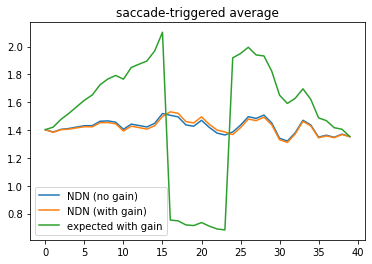

In [97]:
# generate prediction from the two models
Robs = ndn0.generate_prediction(input_data=[stim, sacon])
Robs1 = ndn1.generate_prediction(input_data=[stim, sacon])

ev = np.where(sacon)[0]

cc = 0
m, xax, wf = gt.psth(Robs[:,cc], ev, 0, num_saclags)
m1, xax, wf = gt.psth(Robs1[:,cc], ev, 0, num_saclags)

plt.plot(xax, m)
plt.plot(xax, m1)
plt.plot(xax, m*(sk+1))
plt.title("saccade-triggered average")
plt.legend(["NDN (no gain)", "NDN (with gain)", "expected with gain"])




Text(0.5, 1.0, 'residuals')

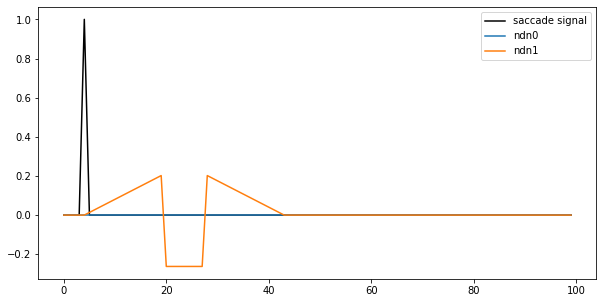

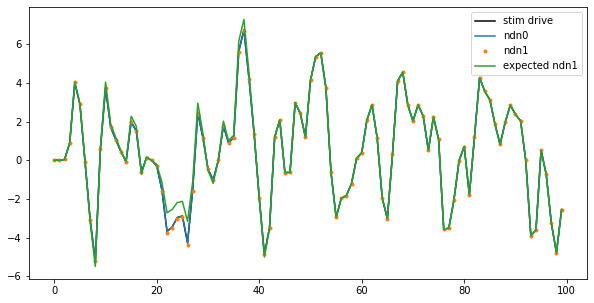

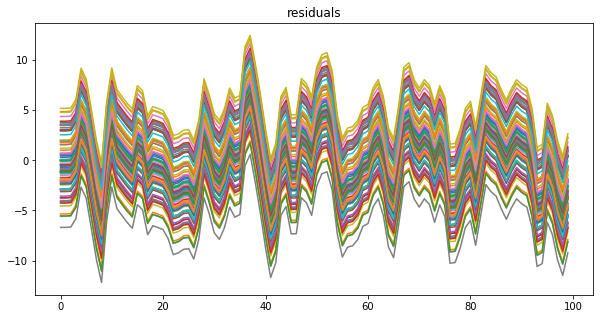

In [102]:
i = 0
ix = np.arange(i, i+100)


sacg0 = ndn0.generate_prediction(input_data=[stim, sacon], ffnet_target=1, layer_target=0)
sacg = ndn1.generate_prediction(input_data=[stim, sacon], ffnet_target=1, layer_target=0)

stimdrive = ndn1.generate_prediction(input_data=[stim, sacon], ffnet_target=0, layer_target=1)
gpre = ndn1.generate_prediction(input_data=[stim, sacon], pre_activation=True)
gpre0 = ndn0.generate_prediction(input_data=[stim, sacon], pre_activation=True)

plt.figure(figsize=(10,5))
plt.plot(sacon[ix], 'k')
plt.plot(sacg0[ix])
plt.plot(sacg[ix])
plt.legend(["saccade signal", "ndn0", "ndn1"])

plt.figure(figsize=(10,5))
plt.plot(stimdrive[ix,cc], 'k')
plt.plot(gpre0[ix,cc], '-')
plt.plot(gpre[ix,cc], '.')
expected = stimdrive[ix,cc:cc+1] * (1 + sacg[ix])
f = plt.plot(expected, '-')
plt.legend(["stim drive", "ndn0", "ndn1", "expected ndn1"])

plt.figure(figsize=(10,5))
plt.plot(expected - gpre[ix,cc])
plt.title('residuals')


